In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta
from pandas.tseries.offsets import MonthEnd, BDay, Week

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from itertools import product

import time

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statistics import mean

import pandas_ta as ta

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
print(sys.version)


3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:37:07) [Clang 15.0.7 ]


In [3]:


def plot_predictions(data, train_predictions, test_predictions, scaler):
    """
    Plot actual data along with train and test predictions, using dates on the x-axis.

    Parameters:
    - data: The original DataFrame containing the actual target values.
    - train_predictions: Predicted values for the train dataset (scaled).
    - test_predictions: Predicted values for the test dataset (scaled).
    - scaler: Fitted scaler object used to inverse transform the scaled predictions.
    """
    # Ensure the index is used as the x-axis (datetime index)
    dates = data.index

    # Inverse transform the actual data to the original scale
    actual_data2 = data['Log_Return'].values.reshape(-1, 1)
    actual_data = scaler.inverse_transform(data['Log_Return'].values.reshape(-1, 1))

    # Prepare placeholders for plotting train and test predictions
    train_predict_plot = np.empty_like(actual_data)
    train_predict_plot[:] = np.nan
    train_predict_plot[:len(train_predictions)] = scaler.inverse_transform(train_predictions.reshape(-1, 1))

    test_predict_plot = np.empty_like(actual_data)
    test_predict_plot[:] = np.nan
    test_predict_plot[len(train_predictions):len(train_predictions) + len(test_predictions)] = scaler.inverse_transform(test_predictions.reshape(-1, 1))

    train_dates = data.index[:len(train_predictions)]
    test_dates = data.index[len(train_predictions):len(train_predictions) + len(test_predictions)]

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Log_Return'], label="Actual Data", color="blue")
    plt.plot(train_dates, scaler.inverse_transform(train_predictions.reshape(-1, 1)), label="Train Predictions", color="orange")
    plt.plot(test_dates, scaler.inverse_transform(test_predictions.reshape(-1, 1)), label="Test Predictions", color="green")
    plt.title("Train and Test Predictions")
    plt.xlabel("Date")
    plt.ylabel("Value (Original Scale)")
    plt.legend()
    plt.grid()
    plt.show()

def calculate_metrics(y_true, y_pred, scaler):
    """
    Calculates RMSE and MAE evaluation metrics before and after inverse transformation.
    
    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.
    - scaler: The target scaler used for inverse transformation.
    
    Returns:
    - RMSE and MAE values before and after inverse transformation.
    """
    # Compute metrics before inverse transformation
    rmse_scaled = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_scaled = mean_absolute_error(y_true, y_pred)
    
    print(f"Scaled RMSE: {rmse_scaled}, Scaled MAE: {mae_scaled}")
    
    # Compute metrics after inverse transformation
    y_true_original = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    rmse_original = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
    mae_original = mean_absolute_error(y_true_original, y_pred_original)
    
    print(f"Original RMSE: {rmse_original}, Original MAE: {mae_original}")
    
    return rmse_original, mae_original

In [4]:

# Step 1: Split the data
def split_data(data, max_lag, sma_windows, train_start, train_end, test_start, test_end):
    """
    Splits the dataset into training and testing sets with lagged log returns, SMA, and RSI features.
    """
    # Generate lagged log return features
    for lag in range(1, max_lag + 1):
        data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)

    # Generate SMA features
    for window in sma_windows:
        data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()
    
    # Compute RSI directly
    data['RSI_14'] = ta.rsi(data['Log_Return'], length=14)
    
    # Drop rows with NaN values due to lagging, SMA, and RSI calculation
    data = data.dropna()
    
    # Split data into train and test sets based on provided dates
    train_size = int(len(data) * 0.75)
    train_data, test_data = data[:train_size], data[train_size:]
    
    # Extract features (X) and target (y)
    feature_columns = [f'Lagged_Log_Return_{lag}' for lag in range(1, max_lag + 1)] + \
                      [f'SMA_{window}' for window in sma_windows] + \
                      ['RSI_14']  # Add RSI feature
    
    X_train = train_data[feature_columns]
    y_train = train_data['Log_Return']
    X_test = test_data[feature_columns]
    y_test = test_data['Log_Return']
    
    return X_train, X_test, y_train, y_test



# Step 2: Scale the data

def scale_data(X_train, X_test, y_train, y_test):
    # Create scalers for features and target
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()
    
    # Scale features
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)
    
    # Scale target variable
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler

# Step 3: Model training with hyperparameter tuning
def model_training(train_data_scaled, y_train):
    best_model = None
    best_score = float('-inf')
    best_params = None  # Store the best parameters

    hyperparameters = {
        'cov_type': ['HC0', 'HC1'],
        'use_t': [True, False],
        'method': ['pinv', 'qr']
    }

    for params in product(*hyperparameters.values()):
        try:
            model = sm.OLS(y_train, train_data_scaled)
            fitted_model = model.fit(cov_type=params[0], use_t=params[1], method=params[2])
            if fitted_model.rsquared_adj > best_score:
                best_model = fitted_model
                best_score = fitted_model.rsquared_adj
                best_params = params  # Save the best hyperparameters
        except Exception as e:
            print(f"Error with params {params}: {e}")

    return best_model, best_params


# Step 4: Main workflow


def train_final_model(data, max_lag, sma_windows,feature_scaler, target_scaler, best_params):
    
    X_full, _, y_full, _ = split_data(data, max_lag,sma_windows, "2000-01-01", "2021-12-31", None, None)
    X_full_scaled = feature_scaler.transform(X_full)
    y_full_scaled = target_scaler.transform(y_full.values.reshape(-1, 1))

    final_model = sm.OLS(y_full_scaled, X_full_scaled).fit(
        cov_type=best_params[0],
        use_t=best_params[1],
        method=best_params[2]
    )

    return final_model

In [5]:
def forecast_future(data, model, scaler, max_lag, sma_windows, start_date="2022-01-01", end_date="2022-12-31"):
    """Forecast future log returns using the trained model with lagged returns, SMA, and RSI features."""
    if model is None:
        raise ValueError("Cannot forecast because the model is not trained.")
    
    lagged_features = data.iloc[-1, :][[f'Lagged_Log_Return_{i}' for i in range(1, max_lag + 1)]].values
    sma_features = data.iloc[-1, :][[f'SMA_{w}' for w in sma_windows]].values
    rsi_feature = data.iloc[-1, :]['RSI_14']
    
    future_dates = pd.date_range(start=start_date, end=end_date, freq="B")  
    future_forecasts = pd.DataFrame(index=future_dates)
    future_forecasts['Forecasted_Log_Return'] = np.nan
    
    for date in future_forecasts.index:
        input_features = np.hstack((lagged_features, sma_features, [rsi_feature]))
        forecasted_scaled = model.predict(input_features.reshape(1, -1))[0]
        forecasted_original = scaler.inverse_transform([[forecasted_scaled]])[0][0]
        future_forecasts.at[date, 'Forecasted_Log_Return'] = forecasted_original
        
        # Update lagged features
        lagged_features = np.roll(lagged_features, -1)
        lagged_features[-1] = forecasted_scaled
        
        # Update SMA values dynamically
        new_sma_values = []
        for window in sma_windows:
            recent_returns = np.concatenate(([forecasted_original], data['Log_Return'].values[-(window - 1):]))
            new_sma_values.append(np.mean(recent_returns))
        sma_features = np.array(new_sma_values)
        
        # Update RSI dynamically
        data['Log_Return'].iloc[-1] = forecasted_original  # Append forecasted return
        data['RSI_14'] = ta.rsi(data['Log_Return'], length=14)
        rsi_feature = data.iloc[-1, :]['RSI_14']
    
    return future_forecasts

In [6]:
def group_forecasts(forecast_df, year):
    """
    Groups the forecasted log returns month-wise and week-wise based on the given year.
    
    Parameters:
    - forecast_df: DataFrame with forecasted log returns indexed by date.
    - year: Year for which weeks should be grouped.
    
    Returns:
    - Dictionary with forecasted log returns per month and per week as lists.
    """
    forecast_df['Month'] = forecast_df.index.to_period('M')
    forecast_df['Week'] = forecast_df.index.to_period('W-SUN')  # Ensure weeks align with trading days
    
    grouped_month_forecast = {f"forecast_predictions_df_{i+1}m": values for i, (key, values) in enumerate(forecast_df.groupby('Month')['Forecasted_Log_Return'].apply(list).items())}
    grouped_week_forecast = {f"forecast_predictions_df_{i+1}w": values for i, (key, values) in enumerate(forecast_df[forecast_df.index.year == year].groupby(pd.Grouper(freq='W-FRI'))['Forecasted_Log_Return'].apply(list).items())}
    
    return grouped_month_forecast, grouped_week_forecast


In [7]:
# Step 7: Main Function
def main(data):
    max_lag = 80
    train_start, train_end = "2000-01-01", "2014-12-31"
    test_start, test_end = "2015-01-01", "2022-01-01"
    sma_windows = [5,10,15]
    # Split Data for Evaluation
    X_train, X_test, y_train, y_test = split_data(data, max_lag,sma_windows, train_start, train_end, test_start, test_end)

    # Scale Data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler = scale_data(X_train, X_test, y_train, y_test)

    # Train Model on Train Set (`2000-2014`)
    start_time = time.time()    
    best_model, best_params = model_training(X_train_scaled, y_train)
    end_time = time.time()
    computaton_time = end_time - start_time
    print(f"Computation Time: {computaton_time:.2f} seconds")
    
    # Generate Predictions
    train_predictions_scaled = best_model.predict(X_train_scaled)
    test_predictions_scaled = best_model.predict(X_test_scaled)

    
    # Evaluate Train-Test Performance
    train_rmse, train_mae = calculate_metrics(y_train_scaled, train_predictions_scaled, target_scaler)
    test_rmse, test_mae = calculate_metrics(y_test_scaled, test_predictions_scaled, target_scaler)

    print(f"Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}")
    # Step 6: Compute evaluation metrics
    
    model_metrics={
                "training_set":{
                    "mae" : train_mae,
                    "rmse" : train_rmse
                },
                "test_set":{
                    "mae" : test_mae,
                    "rmse" : test_rmse
                },
                "time":computaton_time
                
        }

    #plot_predictions(data, y_train_scaled, y_test_scaled, target_scaler)
    
    # Train Final Model on Full Dataset (`2000-2023`)
    final_model = train_final_model(data, max_lag,sma_windows, feature_scaler, target_scaler, best_params)

    # Forecast Future (`2022`)
    future_predictions = forecast_future(data, final_model, target_scaler, max_lag, sma_windows,start_date="2022-01-01", end_date="2022-12-31" )

    print("Future Predictions:")
    print(future_predictions)

    return final_model, future_predictions, model_metrics

In [8]:
def run_workflow(tickers):
    """
    Runs the workflow for multiple stock tickers.
    """
    results = {}
    
    for ticker in tickers:
        print(f"Processing {ticker}...")
        
        # Step 1: Download data
        data = yf.download(ticker, start="2000-01-01", end="2021-12-31")
        
        # Step 2: Compute log returns
        data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
        
        # Step 3: Drop NaN values
        data = data.dropna()
        
        # Step 4: Ensure index is datetime
        data.index = pd.to_datetime(data.index)
        
        # Step 5: Run the main function
        final_model, future_predictions, model_metrics = main(data)
        
        # Step 6: Group forecasted returns month-wise and week-wise for 2022
        monthly_forecasts, weekly_forecasts = group_forecasts(future_predictions, year=2022)
        
        # Step 7: Store results in a dictionary
        results[ticker] = {
            #"final_model": final_model,
            #"future_predictions": future_predictions,
            "monthly_forecast_results": monthly_forecasts,
            "weekly_forecast_results": weekly_forecasts,
            "model_metrics": model_metrics
        }
    
    return results

# List of tickers to process
tickers = ['SMH', 'SOXX', 'PSI', 'XSD', 'IYW', 'XLK', 'VGT', 'QQQ', 'IGM', 'IXN']

#tickers = ['SMH', 'SOXX']

#tickers = ['SMH', 'SOXX', 'PSI','XSD', 'IYW', 'XLK', 'VGT',]

# Execute the workflow for multiple tickers
results = run_workflow(tickers)


Processing SMH...


[*********************100%%**********************]  1 of 1 completed


Computation Time: 0.42 seconds
Scaled RMSE: 0.9776900244871001, Scaled MAE: 0.6781252396353364
Original RMSE: 0.02181226885763459, Original MAE: 0.0151289771559585
Scaled RMSE: 0.8275147102864124, Scaled MAE: 0.581894179329783
Original RMSE: 0.01846185692022777, Original MAE: 0.012982061766348045
Train RMSE: 0.0218, Train MAE: 0.0151
Test RMSE: 0.0185, Test MAE: 0.0130
Future Predictions:
            Forecasted_Log_Return
2022-01-03              -0.000354
2022-01-04              -0.000832
2022-01-05              -0.001321
2022-01-06              -0.000306
2022-01-07              -0.000121
2022-01-10               0.000913
2022-01-11               0.001306
2022-01-12               0.000591
2022-01-13               0.000806
2022-01-14              -0.000127
2022-01-17               0.001015
2022-01-18               0.000976
2022-01-19               0.000101
2022-01-20              -0.000148
2022-01-21              -0.000266
2022-01-24              -0.000502
2022-01-25               0.000

[*********************100%%**********************]  1 of 1 completed


Computation Time: 0.34 seconds
Scaled RMSE: 0.9800434209550979, Scaled MAE: 0.7066535399944498
Original RMSE: 0.019558313997726676, Original MAE: 0.01410238722825913
Scaled RMSE: 0.955807432693256, Scaled MAE: 0.6653698847614494
Original RMSE: 0.01907464658224791, Original MAE: 0.01327850669933927
Train RMSE: 0.0196, Train MAE: 0.0141
Test RMSE: 0.0191, Test MAE: 0.0133
Future Predictions:
            Forecasted_Log_Return
2022-01-03              -0.000200
2022-01-04              -0.000443
2022-01-05              -0.001152
2022-01-06              -0.000392
2022-01-07              -0.000199
2022-01-10               0.000728
2022-01-11               0.000982
2022-01-12               0.000739
2022-01-13               0.001022
2022-01-14               0.000067
2022-01-17               0.001079
2022-01-18               0.001115
2022-01-19              -0.000036
2022-01-20               0.000004
2022-01-21              -0.000353
2022-01-24              -0.000536
2022-01-25               0.00

[*********************100%%**********************]  1 of 1 completed


Computation Time: 0.30 seconds
Scaled RMSE: 0.9827190309998386, Scaled MAE: 0.7272216461943697
Original RMSE: 0.016982065365468237, Original MAE: 0.012566893630106395
Scaled RMSE: 1.2492587869115552, Scaled MAE: 0.8882866131547439
Original RMSE: 0.021588056920128038, Original MAE: 0.015350207792879034
Train RMSE: 0.0170, Train MAE: 0.0126
Test RMSE: 0.0216, Test MAE: 0.0154
Future Predictions:
            Forecasted_Log_Return
2022-01-03              -0.000083
2022-01-04              -0.000371
2022-01-05              -0.000657
2022-01-06               0.000354
2022-01-07               0.000518
2022-01-10               0.001434
2022-01-11               0.001647
2022-01-12               0.000959
2022-01-13               0.001449
2022-01-14               0.000626
2022-01-17               0.001558
2022-01-18               0.001425
2022-01-19               0.000506
2022-01-20               0.000235
2022-01-21               0.000180
2022-01-24               0.000095
2022-01-25               

[*********************100%%**********************]  1 of 1 completed


Computation Time: 0.24 seconds
Scaled RMSE: 0.9819436955309143, Scaled MAE: 0.7216113683598667
Original RMSE: 0.017731009012888814, Original MAE: 0.013030174473775628
Scaled RMSE: 1.176316373330562, Scaled MAE: 0.8409664448478522
Original RMSE: 0.021240806690301955, Original MAE: 0.015185375374371335
Train RMSE: 0.0177, Train MAE: 0.0130
Test RMSE: 0.0212, Test MAE: 0.0152
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.000064
2022-01-04              -0.000147
2022-01-05              -0.001040
2022-01-06              -0.000271
2022-01-07              -0.000182
2022-01-10               0.000922
2022-01-11               0.001026
2022-01-12               0.000933
2022-01-13               0.001442
2022-01-14               0.000470
2022-01-17               0.001503
2022-01-18               0.001295
2022-01-19              -0.000021
2022-01-20               0.000005
2022-01-21              -0.000369
2022-01-24              -0.000294
2022-01-25               0

[*********************100%%**********************]  1 of 1 completed


Computation Time: 0.35 seconds
Scaled RMSE: 0.9823988387810314, Scaled MAE: 0.6603418539142237
Original RMSE: 0.017291360342712548, Original MAE: 0.011622783430376909
Scaled RMSE: 0.8509061694564811, Scaled MAE: 0.5584152078323561
Original RMSE: 0.014976936670818602, Original MAE: 0.009828756100181198
Train RMSE: 0.0173, Train MAE: 0.0116
Test RMSE: 0.0150, Test MAE: 0.0098
Future Predictions:
            Forecasted_Log_Return
2022-01-03              -0.000185
2022-01-04              -0.000429
2022-01-05              -0.000854
2022-01-06              -0.000340
2022-01-07              -0.000199
2022-01-10               0.000433
2022-01-11               0.000559
2022-01-12               0.000498
2022-01-13               0.000538
2022-01-14              -0.000114
2022-01-17               0.000459
2022-01-18               0.000156
2022-01-19              -0.000483
2022-01-20              -0.000416
2022-01-21              -0.000354
2022-01-24              -0.000360
2022-01-25               

[*********************100%%**********************]  1 of 1 completed


Computation Time: 0.31 seconds
Scaled RMSE: 0.9835806697021442, Scaled MAE: 0.6636851797088708
Original RMSE: 0.01614973589042587, Original MAE: 0.01089726617943184
Scaled RMSE: 0.897195900250261, Scaled MAE: 0.5762444747240661
Original RMSE: 0.014731355828091264, Original MAE: 0.009461548362808953
Train RMSE: 0.0161, Train MAE: 0.0109
Test RMSE: 0.0147, Test MAE: 0.0095
Future Predictions:
            Forecasted_Log_Return
2022-01-03              -0.000275
2022-01-04              -0.000504
2022-01-05              -0.000842
2022-01-06              -0.000300
2022-01-07              -0.000168
2022-01-10               0.000406
2022-01-11               0.000522
2022-01-12               0.000392
2022-01-13               0.000387
2022-01-14              -0.000223
2022-01-17               0.000288
2022-01-18               0.000011
2022-01-19              -0.000589
2022-01-20              -0.000470
2022-01-21              -0.000386
2022-01-24              -0.000436
2022-01-25               0.0

[*********************100%%**********************]  1 of 1 completed


Computation Time: 0.25 seconds
Scaled RMSE: 0.9871953296571181, Scaled MAE: 0.6835418167516203
Original RMSE: 0.012639757784444426, Original MAE: 0.008751867781101066
Scaled RMSE: 1.2448458100893955, Scaled MAE: 0.8223474817369545
Original RMSE: 0.01593863853060927, Original MAE: 0.010529094568765005
Train RMSE: 0.0126, Train MAE: 0.0088
Test RMSE: 0.0159, Test MAE: 0.0105
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.000207
2022-01-04               0.000050
2022-01-05              -0.000333
2022-01-06               0.000035
2022-01-07               0.000167
2022-01-10               0.000601
2022-01-11               0.000738
2022-01-12               0.000733
2022-01-13               0.000763
2022-01-14               0.000288
2022-01-17               0.000711
2022-01-18               0.000467
2022-01-19              -0.000006
2022-01-20               0.000080
2022-01-21               0.000092
2022-01-24               0.000079
2022-01-25               0

[*********************100%%**********************]  1 of 1 completed


Computation Time: 0.39 seconds
Scaled RMSE: 0.9823793052048682, Scaled MAE: 0.6560292084376548
Original RMSE: 0.017310194403721002, Original MAE: 0.01155968277467612
Scaled RMSE: 0.767035317170659, Scaled MAE: 0.5001847794879747
Original RMSE: 0.013515686236870566, Original MAE: 0.008813597481996565
Train RMSE: 0.0173, Train MAE: 0.0116
Test RMSE: 0.0135, Test MAE: 0.0088
Future Predictions:
            Forecasted_Log_Return
2022-01-03              -0.000167
2022-01-04              -0.000450
2022-01-05              -0.000898
2022-01-06              -0.000405
2022-01-07              -0.000192
2022-01-10               0.000511
2022-01-11               0.000480
2022-01-12               0.000471
2022-01-13               0.000666
2022-01-14              -0.000005
2022-01-17               0.000664
2022-01-18               0.000395
2022-01-19              -0.000414
2022-01-20              -0.000374
2022-01-21              -0.000309
2022-01-24              -0.000361
2022-01-25               0.

[*********************100%%**********************]  1 of 1 completed


Computation Time: 0.34 seconds
Scaled RMSE: 0.9848281940374004, Scaled MAE: 0.6830570472558977
Original RMSE: 0.01494162226643277, Original MAE: 0.010363208982352663
Scaled RMSE: 0.9615932817784895, Scaled MAE: 0.6315252187860617
Original RMSE: 0.014589106686082546, Original MAE: 0.009581378079910352
Train RMSE: 0.0149, Train MAE: 0.0104
Test RMSE: 0.0146, Test MAE: 0.0096
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.000069
2022-01-04              -0.000128
2022-01-05              -0.000505
2022-01-06              -0.000106
2022-01-07               0.000026
2022-01-10               0.000479
2022-01-11               0.000637
2022-01-12               0.000518
2022-01-13               0.000577
2022-01-14               0.000175
2022-01-17               0.000652
2022-01-18               0.000444
2022-01-19              -0.000059
2022-01-20              -0.000097
2022-01-21              -0.000063
2022-01-24              -0.000091
2022-01-25               0

[*********************100%%**********************]  1 of 1 completed


Computation Time: 0.24 seconds
Scaled RMSE: 0.9857340999893978, Scaled MAE: 0.6706545048158301
Original RMSE: 0.014062384107489705, Original MAE: 0.009567490107362568
Scaled RMSE: 1.061523028374041, Scaled MAE: 0.6922440268563166
Original RMSE: 0.01514358138173572, Original MAE: 0.009875484070068842
Train RMSE: 0.0141, Train MAE: 0.0096
Test RMSE: 0.0151, Test MAE: 0.0099
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.000016
2022-01-04              -0.000209
2022-01-05              -0.000505
2022-01-06              -0.000079
2022-01-07               0.000065
2022-01-10               0.000555
2022-01-11               0.000641
2022-01-12               0.000523
2022-01-13               0.000550
2022-01-14               0.000076
2022-01-17               0.000547
2022-01-18               0.000369
2022-01-19              -0.000191
2022-01-20              -0.000124
2022-01-21              -0.000068
2022-01-24              -0.000126
2022-01-25               0.

In [9]:
computation_time = []
for ticker in tickers:
    print(results[ticker].get("model_metrics", {}).get("time", {}))
    computation_time.append(results[ticker].get("model_metrics", {}).get("time", {})) 
    
total_time = sum(computation_time)
avg_time = mean(computation_time)

print(total_time)
print(avg_time)

0.41901087760925293
0.3362002372741699
0.29784703254699707
0.2449040412902832
0.3461802005767822
0.31095385551452637
0.2466139793395996
0.3926689624786377
0.33775997161865234
0.24199986457824707
3.1741390228271484
0.3174139022827148


Overall mean Training MAE: 0.011759073174340082
Overall mean Test MAE: 0.01148860102966686
Overall mean Training RMSE: 0.016847871202894465
Overall mean Test RMSE: 0.016926067244711365
Total time elapsed to run the model: 3.17 seconds
Average time consumed by model to train on an ETF: 0.32 seconds


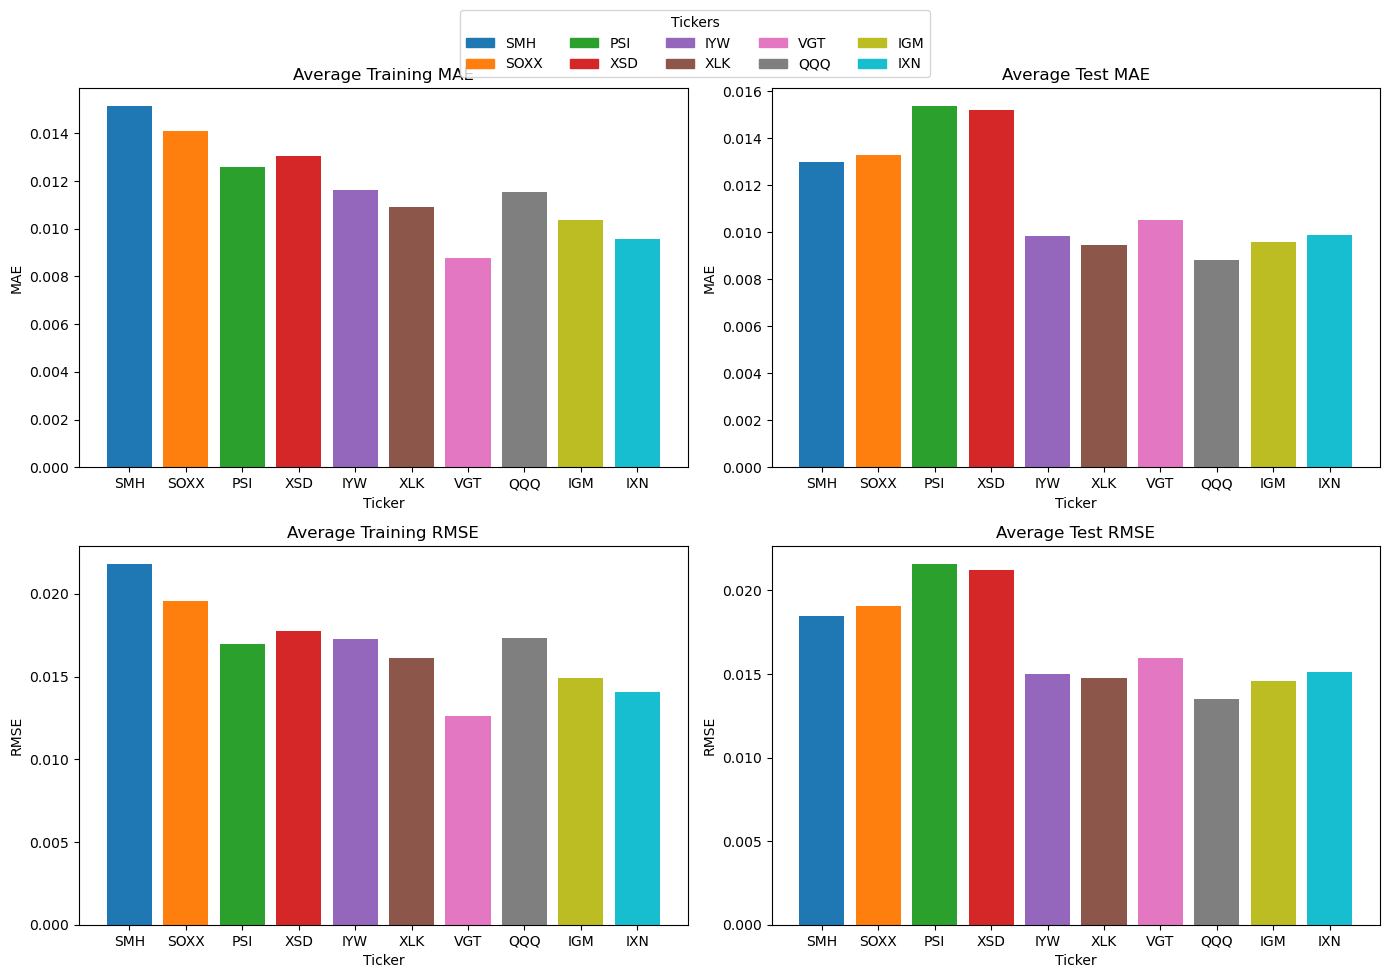

In [10]:
def plot_model_metrics(tickers, results):
    
    
    # --- 1. Gather metrics from 'results' for each ticker ---
    avg_training_mae = []
    avg_test_mae = []
    avg_training_rmse = []
    avg_test_rmse = []

    computation_time = []
    
    for ticker in tickers:
        model_metrics = results[ticker].get("model_metrics", {})
        
        train_set = model_metrics.get("training_set", {})
        test_set = model_metrics.get("test_set", {})
        
        avg_training_mae.append(train_set.get("mae", float('nan')))
        avg_test_mae.append(test_set.get("mae", float('nan')))
        avg_training_rmse.append(train_set.get("rmse", float('nan')))
        avg_test_rmse.append(test_set.get("rmse", float('nan')))

        computation_time.append(results[ticker].get("model_metrics", {}).get("time", {})) 
    
    # (Optional) Print some global averages if you want
    print("Overall mean Training MAE:", mean(avg_training_mae))
    print("Overall mean Test MAE:", mean(avg_test_mae))
    print("Overall mean Training RMSE:", mean(avg_training_rmse))
    print("Overall mean Test RMSE:", mean(avg_test_rmse))

    print(f"Total time elapsed to run the model: {sum(computation_time):.2f} seconds" )
    print(f"Average time consumed by model to train on an ETF: {mean(computation_time):.2f} seconds", )
    # --- 2. Define a color palette for each ticker (must match the number of tickers) ---
    # Example: 10 distinct colors
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    # If you have more than 10 tickers, you need more colors or a different approach.

    # --- 3. Set up a 2×2 subplot grid ---
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    x_positions = range(len(tickers))  # One position per ticker

    # --- Subplot 1: Average Training MAE ---
    ax = axs[0, 0]
    ax.bar(x_positions, avg_training_mae, color=colors[:len(tickers)])
    ax.set_title("Average Training MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 2: Average Test MAE ---
    ax = axs[0, 1]
    ax.bar(x_positions, avg_test_mae, color=colors[:len(tickers)])
    ax.set_title("Average Test MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 3: Average Training RMSE ---
    ax = axs[1, 0]
    ax.bar(x_positions, avg_training_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Training RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 4: Average Test RMSE ---
    ax = axs[1, 1]
    ax.bar(x_positions, avg_test_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Test RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- 4. Create a single legend for the entire figure ---
    legend_handles = [
        mpatches.Patch(color=c, label=ticker)
        for c, ticker in zip(colors[:len(tickers)], tickers)
    ]
    # Adjust spacing to make room at the top for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.93])

    fig.legend(
        handles=legend_handles,
        title="Tickers",
        loc="upper center",
        bbox_to_anchor=(0.5, 0.98),
        ncol=min(5, len(tickers))  # Use up to 5 columns or fewer if <5 tickers
    )

    plt.show()
plot_model_metrics(tickers, results)

In [11]:
def calculate_sharpe_ratio(returns, annual_risk_free_rate=0.1,period='daily'):
    #excess_returns = rate_of_return(returns) - risk_free_rate
    
    # Convert annual risk-free rate to daily rate
    daily_risk_free_rate = (1 + annual_risk_free_rate) ** (1/252) - 1
    
    # Calculate mean daily log return
    mean_return = np.mean(returns)
    
    # Calculate excess daily log return
    excess_return = mean_return - daily_risk_free_rate
    
    # Calculate standard deviation of daily log returns
    std_return = np.std(returns)
    
    # Print diagnostic information
    #print(f"Mean Daily Log Return: {mean_return}")
    #print(f"Excess Daily Log Return: {excess_return}")
    #print(f"Standard Deviation of Daily Log Returns: {std_return}")
    
    # Check for zero standard deviation to avoid division by zero
    epsilon = 0
    # Check for zero standard deviation to avoid division by zero
    if std_return == 0:
        epsilon = 1e-5 
    
    # Calculate Sharpe ratio
    #sharpe_ratio = (excess_return / std_return) * np.sqrt(252)  # Annualize the Sharpe ratio
    sharpe_ratio = (excess_return / (std_return +  epsilon)) # Annualize the Sharpe ratio

    return sharpe_ratio
    #return excess_returns / np.std(returns)


def calculate_rachev_ratio(returns, lower_percentile=5, upper_percentile=95):
    # Step 1: Sort the returns
    sorted_returns = np.sort(returns)
    
    # Step 2: Determine the percentiles
    lower_threshold = np.percentile(sorted_returns, lower_percentile)
    upper_threshold = np.percentile(sorted_returns, upper_percentile)
    
    # Step 3: Calculate Expected Shortfall (ES)
    es = np.mean(sorted_returns[sorted_returns <= lower_threshold])
    
    # Step 4: Calculate Expected Gain (EG)
    eg = np.mean(sorted_returns[sorted_returns >= upper_threshold])
    
    # Step 5: Compute the Rachev Ratio
    rachev_ratio = eg / -es
    return rachev_ratio


"""def calculate_volatility_clustering(returns):
    squared_returns = returns ** 2
    n = len(squared_returns)
    
    # Mean of squared returns
    mean_squared_returns = np.mean(squared_returns)
    
    # Calculate the numerator and denominator for autocorrelation at lag 1
    numerator = np.sum((squared_returns[:-1] - mean_squared_returns) * (squared_returns[1:] - mean_squared_returns))
    denominator = np.sum((squared_returns - mean_squared_returns) ** 2)
    
    if denominator == 0:
        return 0  # Avoid division by zero
    
    rho_1 = numerator / denominator
    return rho_1"""
def calculate_volatility_clustering(returns):
    # Ensure returns is a NumPy array
    returns = np.array(returns)
    squared_returns = returns ** 2
    n = len(squared_returns)

    # Mean of squared returns
    mean_squared = np.mean(squared_returns)
    clustering = np.sum((squared_returns - mean_squared) ** 2) / (n - 1 if n > 1 else 1)
    return clustering

def calculate_sortino_ratio(log_returns, target_log_return=0.04):
    """
    Calculate the Sortino Ratio using log returns.
    
    Parameters:
    - log_returns (array-like): Array or list of log returns for the period.
    - target_log_return (float): The target log return. Default is 0, which is often used as a benchmark.
    
    Returns:
    - float: The Sortino Ratio.
    """
    # Convert input to a NumPy array for easier calculations
    log_returns = np.array(log_returns)
    
    # Calculate the average period log return (R)
    avg_log_return = np.mean(log_returns)
    
    # Calculate the Target Downside Deviation (TDD)
    downside_deviation = np.sqrt(
        np.mean(np.square(np.maximum(0, target_log_return - log_returns)))
    )
    
    # Calculate Sortino Ratio
    #sortino_ratio_value = (avg_log_return - target_log_return) / downside_deviation
    epsilon = 1e-8
    
    # Add epsilon to downside_deviation to prevent division by zero
    #if downside_deviation == 0:
     #   return np.nan  # Return NaN if downside deviation is zero
    
    # Calculate Sortino Ratio
    sortino_ratio_value = (avg_log_return - target_log_return) / (downside_deviation + epsilon)
    
    return sortino_ratio_value


def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        for month in range(1, 13):
            future_predictions = data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            risk_metrics_results[ticker][f'risk_metrics_{month}m'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
    #print(risk_metrics_results)
    return risk_metrics_results


In [12]:
def calculate_composite_score(
    forecasted_values, risk_percentage, rachev_ratio, sharpe_ratio, sortino_ratio, volatility_clustering, 
    mean_forecast, std_forecast, mean_rachev, std_rachev, mean_sharpe, std_sharpe, mean_sortino, std_sortino, 
    mean_volatility_clustering, std_volatility_clustering
):
    epsilon = 1e-8  # To prevent division by zero
    forecasted_mean = np.mean(forecasted_values)

    # Normalize the components with epsilon
    forecasted_mean_normalized = (forecasted_mean - mean_forecast) / (std_forecast + epsilon)
    rachev_normalized = (rachev_ratio - mean_rachev) / (std_rachev + epsilon)
    sharpe_normalized = (sharpe_ratio - mean_sharpe) / (std_sharpe + epsilon)
    sortino_normalized = (sortino_ratio - mean_sortino) / (std_sortino + epsilon)
    volatility_clustering_normalized = (volatility_clustering - mean_volatility_clustering) / (std_volatility_clustering + epsilon)

    # Composite score calculation
    score = (
        forecasted_mean_normalized
        - (risk_percentage * rachev_normalized)
        + sharpe_normalized
        + sortino_normalized
        - volatility_clustering_normalized
    )

    return score

"""def compute_composite_scores(results, risk_metrics_results, risk_percentage):
    composite_scores = {}
    
    for month in range(1, 13):
        forecasted_values = {
            ticker: data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{month}m']
            composite_scores.setdefault(ticker, {})[f'composite_score_{month}m'] = calculate_composite_score(
                forecasted_values[ticker], risk_percentage, risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                np.mean([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()])
            )
    
    return composite_scores"""

def compute_composite_scores(results, risk_metrics_results, risk_percentages):
    composite_scores = {}
    aggregated_scores = {}
    
    for month in range(1, 13):
        forecasted_values = {
            ticker: data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{month}m']
            composite_scores.setdefault(ticker, {})[f'composite_scores_{month}m'] = {}
            
            for risk_percentage in risk_percentages:
                score = calculate_composite_score(
                    forecasted_values[ticker], risk_percentage, risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                    risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                    np.mean([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()])
                )
                composite_scores[ticker][f'composite_scores_{month}m'][risk_percentage] = score
        
        # Compute aggregated scores per ETF per month
        for ticker in composite_scores:
            aggregated_scores.setdefault(ticker, {})[f'aggregated_score_{month}m'] = np.mean(
                list(composite_scores[ticker][f'composite_scores_{month}m'].values())
            )
    print(composite_scores)
    #return composite_scores, aggregated_scores
    return aggregated_scores

In [15]:
#tickers = ['SMH', 'SOXX', 'PSI']
#results = run_workflow(tickers)
#risk_metrics_results = compute_risk_metrics(results)
#composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentages=[0.1,0.2])
#composite_scores

In [16]:
#portfolios

In [17]:
def select_top_etfs_monthly(df, month_label, return_scores=False):
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        return list(df_sorted.itertuples(index=False, name=None))  # Returns tuples (ETF, Score)
    return list(df_sorted['ETF'])  # Returns only ETF names

def generate_month_ranges(start_date, end_date):
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    month_ranges = []
    while start < end:
        month_start = start
        month_end = (start + timedelta(days=31)).replace(day=1) - timedelta(days=1)
        if month_end > end:
            month_end = end
        month_ranges.append((month_start.strftime('%Y-%m-%d'), month_end.strftime('%Y-%m-%d')))
        start = month_end + timedelta(days=1)
    return month_ranges

def gather_etf_data(tickers, month_ranges):
    etf_histories = {}
    for start_date, end_date in month_ranges:
        month = f"{start_date} to {end_date}"
        etf_histories[month] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            if etf_data.empty:
                print(f"No data found for {ticker} in {month}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[month][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, month, investment_amount=50000):
    ticker_shares = {}
    first_trading_day_start = month.split(" to ")[0]
    for ticker in top_etfs:
        etf_history = etf_histories.get(month, {}).get(ticker)
        if etf_history is not None:
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            if first_trading_day not in etf_history.index:
                first_trading_day = etf_history.index[etf_history.index.searchsorted(first_trading_day)]
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = (investment_amount * 0.9975) / price
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
        else:
            print(f"No data found for {ticker} in {month}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_month, curr_month, ticker_shares, etf_histories):
    print(f"Top 2 ETFs for {prev_month}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_month}: {curr_top_etfs}")
    etf_histories_curr = etf_histories.get(curr_month, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs
    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr:
            price = etf_histories_curr[etf]['Close'].iloc[0]
            selling_values[etf] = shares * price * 0.9975
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")
    for etf_to_buy, etf_to_sell in zip(etfs_to_buy, etfs_to_sell):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = (selling_values[etf_to_sell] * 0.9975) / price
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")
    print(f"Updated ticker shares after {curr_month}: {ticker_shares}")
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}

'''def portfolio(results, risk_percentage=0.2):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)
    portfolios = {
        str(month): select_top_etfs_monthly(
            pd.DataFrame({'ETF': list(composite_scores.keys()), 'Score': [composite_scores[t][f'composite_score_{month}m'] for t in composite_scores]}),
            f'{month}m'
        ) for month in range(1, 13)
    }
    return portfolios'''

'''def portfolio(results, risk_percentage=0.1, return_scores=False):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)
    
    portfolios = {
        str(month): select_top_etfs_monthly(
            pd.DataFrame({'ETF': list(composite_scores.keys()), 'Score': [composite_scores[t][f'composite_score_{month}m'] for t in composite_scores]}),
            f'{month}m',
            return_scores=return_scores
        ) for month in range(1, 13)
    }
    return portfolios
'''



"def portfolio(results, risk_percentage=0.1, return_scores=False):\n    risk_metrics_results = compute_risk_metrics(results)\n    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)\n    \n    portfolios = {\n        str(month): select_top_etfs_monthly(\n            pd.DataFrame({'ETF': list(composite_scores.keys()), 'Score': [composite_scores[t][f'composite_score_{month}m'] for t in composite_scores]}),\n            f'{month}m',\n            return_scores=return_scores\n        ) for month in range(1, 13)\n    }\n    return portfolios\n"

In [18]:

def calculate_smoothing(scores_dict, alpha=0.1):
    smoothed_scores = {}
    previous_values = {}
    sorted_months = sorted(scores_dict.keys(), key=lambda m: int(m))
    for month in sorted_months:
        smoothed_scores[month] = {}
        for etf, raw_score in scores_dict[month].items():
            if etf not in previous_values:
                smoothed_value = float(raw_score)
            else:
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[month][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    return smoothed_scores

def portfolio(results, risk_percentages, return_scores=False):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentages)
    
    # Store all ETF scores per month instead of only top 2 ETFs
    all_scores_per_month = {
        str(month): {
            etf: composite_scores[etf][f'aggregated_score_{month}m']
            for etf in composite_scores
        }
        for month in range(1, 13)
    }
    
    return all_scores_per_month

def portfolio_optimization(results, risk_percentages, smoothing=False):
    all_scores = portfolio(results, risk_percentages, return_scores=True)
    print("\n--- Raw Scores Before Smoothing ---")
    for month, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {scores}")
    
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for month, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Month {month}: {scores}")
        
        # Use smoothed scores to select top 2 ETFs per month
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores if no smoothing
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for month, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {etfs}")
    
    month_ranges = generate_month_ranges('2022-01-01', '2023-01-01')
    etf_histories = gather_etf_data(results.keys(), month_ranges)
    ticker_shares = {}
    ticker_shares_per_month = {}
    
    for i, month_range in enumerate(etf_histories.keys()):
        month_index = str(i + 1)
        top_etfs = portfolios.get(month_index, [])
        if not top_etfs:
            print(f"Warning: No ETFs selected for {month_range}. Skipping trading.")
            continue
        if i == 0:
            ticker_shares = initialize_shares(top_etfs, etf_histories, month_range)
        else:
            prev_month_index = str(i)
            prev_top_etfs = portfolios.get(prev_month_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                month_range,
                ticker_shares,
                etf_histories
            )
        ticker_shares_per_month[month_range] = ticker_shares.copy()
    
    first_trading_day_13m = '2023-01-01'
    month_12_range = list(ticker_shares_per_month.keys())[-1]
    month_13_start = first_trading_day_13m
    month_13_end = '2023-01-06'
    etf_values_13m = {}
    
    if month_12_range in ticker_shares_per_month:
        ticker_shares_12m = ticker_shares_per_month[month_12_range]
        for ticker, shares in ticker_shares_12m.items():
            data = yf.download(ticker, start=month_13_start, end=month_13_end)
            if not data.empty:
                closing_price_13m = data['Close'].iloc[0]
                total_value = shares * closing_price_13m
                etf_values_13m[ticker] = total_value
    
    total_portfolio_value = sum(etf_values_13m.values()) if etf_values_13m else 0
    return ticker_shares_per_month, total_portfolio_value


In [19]:

portfolios, final_value = portfolio_optimization(results, risk_percentages=[0.01, 0.04, 0.1, 0.2], smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")

{'SMH': {'composite_scores_1m': {0.01: 1.0556283495298624, 0.04: 1.0794557095465027, 0.1: 1.1271104295797831, 0.2: 1.206534962968584}, 'composite_scores_2m': {0.01: -1.8551345615880086, 0.04: -1.841507325601449, 0.1: -1.81425285362833, 0.2: -1.768828733673132}, 'composite_scores_3m': {0.01: 2.448962180728378, 0.04: 2.461080489101247, 0.1: 2.485317105846985, 0.2: 2.525711467089882}, 'composite_scores_4m': {0.01: -1.6509243402885463, 0.04: -1.6270315822851324, 0.1: -1.5792460662783043, 0.2: -1.499603539600258}, 'composite_scores_5m': {0.01: 3.3616283353291156, 0.04: 3.349924342241082, 0.1: 3.326516356065014, 0.2: 3.2875030457715684}, 'composite_scores_6m': {0.01: 3.832089334470949, 0.04: 3.8518480586106394, 0.1: 3.8913655068900193, 0.2: 3.9572279206889855}, 'composite_scores_7m': {0.01: -2.721964990055666, 0.04: -2.676451157466085, 0.1: -2.585423492286924, 0.2: -2.433710716988322}, 'composite_scores_8m': {0.01: 4.471879300358977, 0.04: 4.421346979423674, 0.1: 4.320282337553069, 0.2: 4.15

[*********************100%%**********************]  1 of 1 completed

Buy PSI: 959.44 shares at 51.98.
Buy XSD: 200.80 shares at 248.38.
Top 2 ETFs for 2022-01-01 to 2022-01-31: ['PSI', 'XSD']
Top 2 ETFs for 2022-02-01 to 2022-02-28: ['PSI', 'XSD']
Updated ticker shares after 2022-02-01 to 2022-02-28: {'PSI': 959.4421241936759, 'XSD': 200.80118777488303}
Top 2 ETFs for 2022-02-01 to 2022-02-28: ['PSI', 'XSD']
Top 2 ETFs for 2022-03-01 to 2022-03-31: ['PSI', 'XSD']
Updated ticker shares after 2022-03-01 to 2022-03-31: {'PSI': 959.4421241936759, 'XSD': 200.80118777488303}
Top 2 ETFs for 2022-03-01 to 2022-03-31: ['PSI', 'XSD']
Top 2 ETFs for 2022-04-01 to 2022-04-30: ['PSI', 'XSD']
Updated ticker shares after 2022-04-01 to 2022-04-30: {'PSI': 959.4421241936759, 'XSD': 200.80118777488303}
Top 2 ETFs for 2022-04-01 to 2022-04-30: ['PSI', 'XSD']
Top 2 ETFs for 2022-05-01 to 2022-05-31: ['PSI', 'XSD']
Updated ticker shares after 2022-05-01 to 2022-05-31: {'PSI': 959.4421241936759, 'XSD': 200.80118777488303}
Top 2 ETFs for 2022-05-01 to 2022-05-31: ['PSI', 'XSD


[*********************100%%**********************]  1 of 1 completed

Final Portfolio Value: 64839.23


In [20]:

portfolios, final_value = portfolio_optimization(results,risk_percentages=[0.01, 0.04, 0.1, 0.2], smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")

{'SMH': {'composite_scores_1m': {0.01: 1.0556283495298624, 0.04: 1.0794557095465027, 0.1: 1.1271104295797831, 0.2: 1.206534962968584}, 'composite_scores_2m': {0.01: -1.8551345615880086, 0.04: -1.841507325601449, 0.1: -1.81425285362833, 0.2: -1.768828733673132}, 'composite_scores_3m': {0.01: 2.448962180728378, 0.04: 2.461080489101247, 0.1: 2.485317105846985, 0.2: 2.525711467089882}, 'composite_scores_4m': {0.01: -1.6509243402885463, 0.04: -1.6270315822851324, 0.1: -1.5792460662783043, 0.2: -1.499603539600258}, 'composite_scores_5m': {0.01: 3.3616283353291156, 0.04: 3.349924342241082, 0.1: 3.326516356065014, 0.2: 3.2875030457715684}, 'composite_scores_6m': {0.01: 3.832089334470949, 0.04: 3.8518480586106394, 0.1: 3.8913655068900193, 0.2: 3.9572279206889855}, 'composite_scores_7m': {0.01: -2.721964990055666, 0.04: -2.676451157466085, 0.1: -2.585423492286924, 0.2: -2.433710716988322}, 'composite_scores_8m': {0.01: 4.471879300358977, 0.04: 4.421346979423674, 0.1: 4.320282337553069, 0.2: 4.15

[*********************100%%**********************]  1 of 1 completed

Buy PSI: 959.44 shares at 51.98.
Buy XSD: 200.80 shares at 248.38.
Top 2 ETFs for 2022-01-01 to 2022-01-31: ['PSI', 'XSD']
Top 2 ETFs for 2022-02-01 to 2022-02-28: ['PSI', 'XSD']
Updated ticker shares after 2022-02-01 to 2022-02-28: {'PSI': 959.4421241936759, 'XSD': 200.80118777488303}
Top 2 ETFs for 2022-02-01 to 2022-02-28: ['PSI', 'XSD']
Top 2 ETFs for 2022-03-01 to 2022-03-31: ['PSI', 'SMH']
Sell XSD: 200.80 shares at 198.42. Total value: 39743.36
Buy SMH: 305.32 shares at 129.85.
Updated ticker shares after 2022-03-01 to 2022-03-31: {'PSI': 959.4421241936759, 'SMH': 305.317918286645}
Top 2 ETFs for 2022-03-01 to 2022-03-31: ['PSI', 'SMH']
Top 2 ETFs for 2022-04-01 to 2022-04-30: ['VGT', 'XSD']
Sell PSI: 959.44 shares at 42.32. Total value: 40505.27
Sell SMH: 305.32 shares at 132.71. Total value: 40417.45
Buy XSD: 198.76 shares at 203.28.
Buy VGT: 97.09 shares at 415.26.
Updated ticker shares after 2022-04-01 to 2022-04-30: {'XSD': 198.7603764050324, 'VGT': 97.08712990604285}
Top 2


[*********************100%%**********************]  1 of 1 completed

Final Portfolio Value: 53912.04


In [21]:
import numpy as np

def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        # Change range(1, 13) to range(1, 53) and month -> week
        for week in range(1, 53):
            # Change 'monthly_forecast_results' to 'weekly_forecast_results' 
            # and '{month}m' to '{week}w'
            future_predictions = data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            # Rename 'risk_metrics_{month}m' to 'risk_metrics_{week}w'
            risk_metrics_results[ticker][f'risk_metrics_{week}w'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
    return risk_metrics_results



"def compute_composite_scores(results, risk_metrics_results, risk_percentage):\n    composite_scores = {}\n    \n    # Change range(1, 13) to range(1, 53) and month -> week\n    for week in range(1, 53):\n        forecasted_values = {\n            ticker: data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']\n            for ticker, data in results.items()\n        }\n        \n        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])\n        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])\n        \n        for ticker, metrics in risk_metrics_results.items():\n            # Rename risk_metrics_{month}m to risk_metrics_{week}w\n            risk_metrics = metrics[f'risk_metrics_{week}w']\n            \n            # Rename composite_score_{month}m to composite_score_{week}w\n            composite_scores.setdefault(ticker, {})[f'composite_score_{week}w'] = calculate_composite_score(\n                foreca

In [22]:
def compute_composite_scores(results, risk_metrics_results, risk_percentages):
    composite_scores = {}
    aggregated_scores = {}
    
    for week in range(1, 53):
        forecasted_values = {
            ticker: data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{week}w']
            composite_scores.setdefault(ticker, {})[f'composite_scores_{week}w'] = {}
            
            for risk_percentage in risk_percentages:
                score = calculate_composite_score(
                    forecasted_values[ticker], risk_percentage, risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                    risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                    np.mean([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()])
                )
                composite_scores[ticker][f'composite_scores_{week}w'][risk_percentage] = score
        
        # Compute aggregated scores per ETF per month
        for ticker in composite_scores:
            aggregated_scores.setdefault(ticker, {})[f'aggregated_score_{week}w'] = np.mean(
                list(composite_scores[ticker][f'composite_scores_{week}w'].values())
            )
    print(composite_scores)
    #return composite_scores, aggregated_scores
    return aggregated_scores

In [23]:
#tickers = ['SMH', 'SOXX', 'PSI']
#results = run_workflow(tickers)
#risk_metrics_results = compute_risk_metrics(results)
#composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentages=[0.1,0.2])
#composite_scores

{'SMH': {'composite_scores_1w': {0.1: 0.3742943128721188, 0.2: 0.42744535813097917}, 'composite_scores_2w': {0.1: 2.439065268456896, 0.2: 2.442110599334051}, 'composite_scores_3w': {0.1: 1.5422336845690563, 0.2: 1.5691736839408892}, 'composite_scores_4w': {0.1: 0.34461580281881554, 0.2: 0.32405351783629954}, 'composite_scores_5w': {0.1: -0.12954683424687946, 0.2: -0.1573192415985804}, 'composite_scores_6w': {0.1: -1.1296594685288561, 0.2: -1.1255939731915798}, 'composite_scores_7w': {0.1: -1.805969564702037, 0.2: -1.816207662422596}, 'composite_scores_8w': {0.1: 2.3247773259132223, 0.2: 2.3571421135275545}, 'composite_scores_9w': {0.1: -1.5689801949755116, 0.2: -1.5587362514764058}, 'composite_scores_10w': {0.1: -4.074860599556297, 0.2: -3.9985365896640137}, 'composite_scores_11w': {0.1: 1.5685263835834724, 0.2: 1.5539240521127118}, 'composite_scores_12w': {0.1: 3.8323146509357353, 0.2: 3.8399354246581736}, 'composite_scores_13w': {0.1: 3.130294453728999, 0.2: 3.0611780528865897}, 'com

{'SMH': {'aggregated_score_1w': 0.400869835501549,
  'aggregated_score_2w': 2.4405879338954737,
  'aggregated_score_3w': 1.5557036842549727,
  'aggregated_score_4w': 0.33433466032755754,
  'aggregated_score_5w': -0.14343303792272993,
  'aggregated_score_6w': -1.127626720860218,
  'aggregated_score_7w': -1.8110886135623165,
  'aggregated_score_8w': 2.3409597197203884,
  'aggregated_score_9w': -1.5638582232259588,
  'aggregated_score_10w': -4.036698594610155,
  'aggregated_score_11w': 1.561225217848092,
  'aggregated_score_12w': 3.8361250377969545,
  'aggregated_score_13w': 3.0957362533077943,
  'aggregated_score_14w': -1.2533094968060072,
  'aggregated_score_15w': 0.7876811984023886,
  'aggregated_score_16w': 0.5468366091094872,
  'aggregated_score_17w': -1.9911028117716216,
  'aggregated_score_18w': -0.11892320073569512,
  'aggregated_score_19w': -3.5180267786520654,
  'aggregated_score_20w': 4.075680137940125,
  'aggregated_score_21w': 6.1124904744260515,
  'aggregated_score_22w': 4.1

In [24]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

def select_top_etfs_weekly(df, week_label, return_scores=False):
    """
    Select the top 2 ETFs based on 'Score' for the given week_label.
    """
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        # Returns list of tuples (ETF, Score)
        return list(df_sorted.itertuples(index=False, name=None))
    # Returns only ETF names
    return list(df_sorted['ETF'])

def generate_week_ranges(start_date, end_date):
    """
    Generate a list of weekly date ranges from start_date to end_date.
    Each range is 7 days long (e.g., Monday to Sunday).
    """
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    week_ranges = []
    
    while start < end:
        week_start = start
        # Each period is one week long (7 days)
        week_end = start + timedelta(days=6)
        # If the next 7-day block goes beyond end, truncate to end
        if week_end > end:
            week_end = end
        week_ranges.append((week_start.strftime('%Y-%m-%d'), week_end.strftime('%Y-%m-%d')))
        
        # Move to the day after week_end to start the next week
        start = week_end + timedelta(days=1)
    
    return week_ranges

def gather_etf_data_weekly(tickers, week_ranges):
    """
    Download weekly ETF data for the specified tickers over the given weekly ranges.
    Returns a dictionary keyed by 'start_date to end_date', each containing data per ticker.
    """
    etf_histories = {}
    for start_date, end_date in week_ranges:
        week = f"{start_date} to {end_date}"
        etf_histories[week] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            if etf_data.empty:
                print(f"No data found for {ticker} in {week}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[week][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, week, investment_amount=50000):
    """
    Initialize shares for the top ETFs at the beginning of a given 'week'.
    """
    ticker_shares = {}
    # The 'week' string is in the format: "yyyy-mm-dd to yyyy-mm-dd"
    first_trading_day_start = week.split(" to ")[0]
    
    for ticker in top_etfs:
        etf_history = etf_histories.get(week, {}).get(ticker)
        if etf_history is not None and not etf_history.empty:
            # Move one business day forward from the week start
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            # If this exact date isn't in the index, find the nearest future trading day
            if first_trading_day not in etf_history.index:
                idx_pos = etf_history.index.searchsorted(first_trading_day)
                if idx_pos < len(etf_history.index):
                    first_trading_day = etf_history.index[idx_pos]
                else:
                    print(f"No valid trading day found for {ticker} in {week}")
                    continue
            
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = (investment_amount * 0.9975) / price  # small friction cost (0.25%)
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
        else:
            print(f"No data found for {ticker} in {week}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_week, curr_week, ticker_shares, etf_histories):
    """
    Manage the transition from prev_week's top ETFs to curr_week's top ETFs,
    selling ETFs no longer in the top 2, and buying newly selected ETFs.
    """
    print(f"Top 2 ETFs for {prev_week}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_week}: {curr_top_etfs}")
    
    etf_histories_curr = etf_histories.get(curr_week, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs

    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr and not etf_histories_curr[etf].empty:
            # Use the first available Close price in the new week to sell
            price = etf_histories_curr[etf]['Close'].iloc[0]
            selling_values[etf] = shares * price * 0.9975
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")

    # Use zipped pairs to buy new ETFs using the proceeds from sold ETFs
    for etf_to_buy, etf_to_sell in zip(etfs_to_buy, etfs_to_sell):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = (selling_values[etf_to_sell] * 0.9975) / price
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")

    print(f"Updated ticker shares after {curr_week}: {ticker_shares}")
    # Return only shares for the newly selected top ETFs
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}




In [25]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

##############################################
# Assume you already have these functions:
#   - compute_risk_metrics(results)
#   - compute_composite_scores(results, risk_metrics_results, risk_percentage)
#   - select_top_etfs_weekly()  (similar to select_top_etfs_monthly but for weeks)
#   - generate_week_ranges()
#   - gather_etf_data_weekly()
#   - initialize_shares()
#   - manage_portfolio()
##############################################

def calculate_smoothing(scores_dict, alpha=0.1):
    """
    Apply exponential smoothing to a dictionary of dictionaries containing scores.
    Keys at the top level are weeks (as strings), and values are {etf: raw_score}.
    """
    smoothed_scores = {}
    previous_values = {}
    # Sort by the numeric value of the week string (e.g., '1', '2', ..., '52')
    sorted_weeks = sorted(scores_dict.keys(), key=lambda w: int(w))
    
    for week in sorted_weeks:
        smoothed_scores[week] = {}
        for etf, raw_score in scores_dict[week].items():
            if etf not in previous_values:
                # First time seeing this ETF, just take the raw score
                smoothed_value = float(raw_score)
            else:
                # Exponential smoothing
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[week][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    
    return smoothed_scores

def portfolio_weekly(results, risk_percentages, return_scores=False):
    """
    Compute risk metrics and composite scores on a weekly basis.
    Return a dictionary of all ETF scores per week (rather than just the top 2).
    """
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentages)
    
    # Collect all ETF scores per week
    # Instead of composite_score_{month}m, we use composite_score_{week}w
    all_scores_per_week = {
        str(week): {
            etf: composite_scores[etf][f'aggregated_score_{week}w']
            for etf in composite_scores
        }
        for week in range(1, 53)  # 1 to 52 for weeks in a year, adjust as needed
    }
    
    return all_scores_per_week

def portfolio_optimization_weekly(results, risk_percentages, smoothing=False):
    """
    High-level function to:
      - Get all raw weekly scores
      - Optionally apply smoothing
      - Select top ETFs each week
      - Manage portfolio transitions through the weeks
      - Calculate final portfolio value after a certain 'week 53' period or next horizon
    """
    # 1) Get all raw weekly scores
    all_scores = portfolio_weekly(results, risk_percentages, return_scores=True)
    
    print("\n--- Raw Scores Before Smoothing ---")
    for week, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {scores}")
    
    # 2) Optionally apply smoothing
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for week, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Week {week}: {scores}")
        
        # Select top 2 ETFs based on smoothed scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for week, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {etfs}")
    
    # 3) Gather weekly data for the actual buy/sell simulation
    #    Replace this range with your desired start/end for weekly intervals
    week_ranges = generate_week_ranges('2022-01-01', '2022-12-31')
    etf_histories = gather_etf_data_weekly(results.keys(), week_ranges)
    
    # Keep track of shares after each week
    ticker_shares = {}
    ticker_shares_per_week = {}
    
    # 4) Loop through the weeks in etf_histories
    for i, week_range in enumerate(etf_histories.keys()):
        week_index = str(i + 1)  # '1', '2', '3', ...
        top_etfs = portfolios.get(week_index, [])
        
        if not top_etfs:
            print(f"Warning: No ETFs selected for {week_range}. Skipping trading.")
            continue
        
        if i == 0:
            # First week: initialize shares
            ticker_shares = initialize_shares(top_etfs, etf_histories, week_range)
        else:
            # Manage portfolio transitions from previous week
            prev_week_index = str(i)
            prev_top_etfs = portfolios.get(prev_week_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                week_range,
                ticker_shares,
                etf_histories
            )
        
        ticker_shares_per_week[week_range] = ticker_shares.copy()
    
    # 5) Simulate final valuation after "Week 53" or any next horizon
    #    For illustration, let's say it's a few days into 2025.
    first_trading_day_53w = '2023-01-01'
    week_52_range = list(ticker_shares_per_week.keys())[-1] if ticker_shares_per_week else None
    
    # We can define a short window for the next week:
    week_53_start = first_trading_day_53w
    week_53_end = '2023-01-06'
    etf_values_53w = {}
    
    if week_52_range and week_52_range in ticker_shares_per_week:
        ticker_shares_52w = ticker_shares_per_week[week_52_range]
        for ticker, shares in ticker_shares_52w.items():
            data = yf.download(ticker, start=week_53_start, end=week_53_end, progress=False)
            if not data.empty:
                closing_price_53w = data['Close'].iloc[0]
                total_value = shares * closing_price_53w
                etf_values_53w[ticker] = total_value
    
    total_portfolio_value = sum(etf_values_53w.values()) if etf_values_53w else 0
    
    return ticker_shares_per_week, total_portfolio_value


In [26]:
#results


In [27]:

portfolios, final_value = portfolio_optimization_weekly(results,risk_percentages=[0.01, 0.04, 0.1, 0.2], smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")

{'SMH': {'composite_scores_1w': {0.01: 0.3264583721391445, 0.04: 0.34240368571680246, 0.1: 0.3742943128721188, 0.2: 0.42744535813097917}, 'composite_scores_2w': {0.01: 2.4363244706674565, 0.04: 2.437238069930603, 0.1: 2.439065268456896, 0.2: 2.442110599334051}, 'composite_scores_3w': {0.01: 1.5179876851344067, 0.04: 1.5260696849459565, 0.1: 1.5422336845690563, 0.2: 1.5691736839408892}, 'composite_scores_4w': {0.01: 0.36312185930307983, 0.04: 0.35695317380832514, 0.1: 0.34461580281881554, 0.2: 0.32405351783629954}, 'composite_scores_5w': {0.01: -0.10455166763034855, 0.04: -0.1128833898358587, 0.1: -0.12954683424687946, 0.2: -0.1573192415985804}, 'composite_scores_6w': {0.01: -1.133318414332405, 0.04: -1.1320987657312218, 0.1: -1.1296594685288561, 0.2: -1.1255939731915798}, 'composite_scores_7w': {0.01: -1.7967552767535337, 0.04: -1.7998267060697015, 0.1: -1.805969564702037, 0.2: -1.816207662422596}, 'composite_scores_8w': {0.01: 2.2956490170603234, 0.04: 2.3053584533446227, 0.1: 2.32477


--- Final Portfolio Selection ---
Week 1: ['PSI', 'XSD']
Week 2: ['PSI', 'XSD']
Week 3: ['PSI', 'XSD']
Week 4: ['PSI', 'XSD']
Week 5: ['PSI', 'XSD']
Week 6: ['PSI', 'XSD']
Week 7: ['PSI', 'XSD']
Week 8: ['PSI', 'XSD']
Week 9: ['PSI', 'XSD']
Week 10: ['PSI', 'XSD']
Week 11: ['PSI', 'XSD']
Week 12: ['PSI', 'XSD']
Week 13: ['PSI', 'XSD']
Week 14: ['PSI', 'XSD']
Week 15: ['PSI', 'XSD']
Week 16: ['PSI', 'XSD']
Week 17: ['PSI', 'XSD']
Week 18: ['PSI', 'XSD']
Week 19: ['PSI', 'XSD']
Week 20: ['XSD', 'PSI']
Week 21: ['XSD', 'SOXX']
Week 22: ['SOXX', 'SMH']
Week 23: ['SMH', 'SOXX']
Week 24: ['SMH', 'SOXX']
Week 25: ['SMH', 'XSD']
Week 26: ['SMH', 'XSD']
Week 27: ['SMH', 'XSD']
Week 28: ['XSD', 'SMH']
Week 29: ['XSD', 'PSI']
Week 30: ['XSD', 'PSI']
Week 31: ['XSD', 'PSI']
Week 32: ['XSD', 'PSI']
Week 33: ['PSI', 'XSD']
Week 34: ['PSI', 'XSD']
Week 35: ['PSI', 'XSD']
Week 36: ['PSI', 'XSD']
Week 37: ['PSI', 'XSD']
Week 38: ['PSI', 'XSD']
Week 39: ['PSI', 'XSD']
Week 40: ['PSI', 'XSD']
Week 41: [

In [28]:

portfolios, final_value = portfolio_optimization_weekly(results,risk_percentages=[0.01, 0.04, 0.1, 0.2], smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")

{'SMH': {'composite_scores_1w': {0.01: 0.3264583721391445, 0.04: 0.34240368571680246, 0.1: 0.3742943128721188, 0.2: 0.42744535813097917}, 'composite_scores_2w': {0.01: 2.4363244706674565, 0.04: 2.437238069930603, 0.1: 2.439065268456896, 0.2: 2.442110599334051}, 'composite_scores_3w': {0.01: 1.5179876851344067, 0.04: 1.5260696849459565, 0.1: 1.5422336845690563, 0.2: 1.5691736839408892}, 'composite_scores_4w': {0.01: 0.36312185930307983, 0.04: 0.35695317380832514, 0.1: 0.34461580281881554, 0.2: 0.32405351783629954}, 'composite_scores_5w': {0.01: -0.10455166763034855, 0.04: -0.1128833898358587, 0.1: -0.12954683424687946, 0.2: -0.1573192415985804}, 'composite_scores_6w': {0.01: -1.133318414332405, 0.04: -1.1320987657312218, 0.1: -1.1296594685288561, 0.2: -1.1255939731915798}, 'composite_scores_7w': {0.01: -1.7967552767535337, 0.04: -1.7998267060697015, 0.1: -1.805969564702037, 0.2: -1.816207662422596}, 'composite_scores_8w': {0.01: 2.2956490170603234, 0.04: 2.3053584533446227, 0.1: 2.32477

Buy PSI: 959.44 shares at 51.98.
Buy XSD: 200.80 shares at 248.38.
Top 2 ETFs for 2022-01-01 to 2022-01-07: ['PSI', 'XSD']
Top 2 ETFs for 2022-01-08 to 2022-01-14: ['PSI', 'XSD']
Updated ticker shares after 2022-01-08 to 2022-01-14: {'PSI': 959.4421241936759, 'XSD': 200.80118777488303}
Top 2 ETFs for 2022-01-08 to 2022-01-14: ['PSI', 'XSD']
Top 2 ETFs for 2022-01-15 to 2022-01-21: ['PSI', 'XSD']
Updated ticker shares after 2022-01-15 to 2022-01-21: {'PSI': 959.4421241936759, 'XSD': 200.80118777488303}
Top 2 ETFs for 2022-01-15 to 2022-01-21: ['PSI', 'XSD']
Top 2 ETFs for 2022-01-22 to 2022-01-28: ['PSI', 'IGM']
Sell XSD: 200.80 shares at 202.29. Total value: 40518.52
Buy IGM: 630.45 shares at 64.11.
Updated ticker shares after 2022-01-22 to 2022-01-28: {'PSI': 959.4421241936759, 'IGM': 630.4519957200937}
Top 2 ETFs for 2022-01-22 to 2022-01-28: ['PSI', 'IGM']
Top 2 ETFs for 2022-01-29 to 2022-02-04: ['PSI', 'XSD']
Sell IGM: 630.45 shares at 66.38. Total value: 41741.64
Buy XSD: 203.57 

Final Portfolio Value: 52971.02
